The goal of this notebook is to perform feature selection.
Feature selection becomes relevant after the feature engineering stage. Feature engineering in our pipeline should in the end be automatic. So there has to be a method for selection of best-performing and un-correlated features. Selection of appropriate features also serves as a method for dimensionality reduction. It's a waste of compute to use correlated features in any model. It also decreases complexity and improves readability.

In feature selection, we strive to meet two goals:

Strength: Choose the features with the strongest, most persistent relationships to the target outcome variable. The reasons for this are obvious.

Orthogonality: Minimize the amount of overlap or collinearity in your selected features.



In [6]:
import numpy as np
import csv
from datetime import datetime


# The basic CSV instrument. We'll abstract this later when we need it
class FileInstrument:
    def __init__(self, filename, load=True):
        self.datetime_format = '%d-%b-%Y'
        self.column_names = ['day', 'month', 'year', 'open', 'high', 'low', 'close', 'volume', 'forward_returns']
        self.column_set = set(self.column_names)

        self.data = None

        if load:
            self.load_file(filename)

    def load_file(self, filename):
        with open(filename) as f:
            item = []
            reader = csv.reader(f)
            for row in reader:
                _row = self.format_row(*row)
                item.append(_row)

        item = np.array(item)
        returns = np.expand_dims(np.diff(item[:, -2], append=item[:, -2][-1]), axis=1)

        items_with_returns = np.hstack((item, returns))
        self.data = items_with_returns

    def format_row(self, *args):
        date = datetime.strptime(args[0], self.datetime_format)
        o = float(args[1])
        h = float(args[2])
        l = float(args[3])
        c = float(args[4])
        v = int(args[5])

        return [date.day, date.month, date.year, o, h, l, c, v]

    def attach_feature(self, feature, name):
        assert name not in self.column_set, f'Feature named "{name}" already exists!'

        self.column_set.add(name)
        self.column_names.append(name)

        f = np.expand_dims(feature, axis=1)
        self.data = np.hstack((self.data, f))

    @property
    def features(self):
        return self.column_names

    def __getitem__(self, key):
        if type(key) == str:
            idx = self.column_names.index(key)
            return self.data[:, idx]

        return self.data.__getitem__(key)

    def __repr__(self):
        return self.data.__repr__()


In [10]:
import numpy as np
import random
import scipy.stats as stat
import data_ingest
import csv
import glob
import os.path
from os import path
from datetime import datetime

# Load data

asset = FileInstrument('C:/Users/ck6542/Documents/AlphaEngine/Seasonality generator/prices/prices/NASDAQ/QQQ.csv')

In [11]:
def tn_returns(asset, n=5):
    return np.diff(asset['forward_returns'], n=n, prepend=np.ones(n)*np.nan)

In [12]:
# We already have "forward_returns (t+1)" in the "forward_returns" column of the matrix. But let's add some more lookahead spots to use in our analysis.
# The attach_feature is used for this, it might not be the best solution, but it does the job.

t1_returns = tn_returns(asset,1)
t5_returns = tn_returns(asset,5)
t10_returns = tn_returns(asset,10)
t20_returns = tn_returns(asset,20)

asset.attach_feature(t1_returns, 't1_returns')
asset.attach_feature(t5_returns, 't5_returns')
asset.attach_feature(t10_returns, 't10_returns')
asset.attach_feature(t20_returns, 't20_returns')

In [13]:
import pandas as pd

outcomes = pd.DataFrame(asset[:, -4:])
outcomes.columns =  asset.features[-4:]
print(outcomes)

      t1_returns  t5_returns  t10_returns  t20_returns
0            NaN         NaN          NaN          NaN
1         4.2133         NaN          NaN          NaN
2        -3.6283         NaN          NaN          NaN
3        15.6830         NaN          NaN          NaN
4        -7.3459         NaN          NaN          NaN
...          ...         ...          ...          ...
5214     -0.4000       -4.85       383.71    154436.95
5215      3.5500       18.78      -335.38    -90010.27
5216     -5.5300      -30.55        63.38     89136.64
5217      3.3600       50.18       354.53   -143567.67
5218     -1.3800      -62.60      -817.84    207564.01

[5219 rows x 4 columns]


In [14]:
# Create features

import talib as ta

open = asset['open']
high = asset['high']
low = asset['low']
close = asset['close']

asset.attach_feature(ta.RSI(close, 14), 'RSI_14')
asset.attach_feature(ta.EMA(close, 20), 'EMA_20')
asset.attach_feature(ta.ATR(high,low,close, 20), 'ATR_20')
asset.attach_feature(ta.MOM(close, 10), 'MOM_10')

In [15]:
import pandas as pd

features = pd.DataFrame(asset[:, -4:])
features.columns =  asset.features[-4:]
print(features)

         RSI_14      EMA_20    ATR_20  MOM_10
0           NaN         NaN       NaN     NaN
1           NaN         NaN       NaN     NaN
2           NaN         NaN       NaN     NaN
3           NaN         NaN       NaN     NaN
4           NaN         NaN       NaN     NaN
...         ...         ...       ...     ...
5214  70.656124  209.460026  1.739841    3.22
5215  70.656124  209.760023  1.652849    3.06
5216  78.250157  210.369545  1.747706    5.30
5217  67.722966  210.732445  1.804321    2.47
5218  70.683301  211.192213  1.881605    3.75

[5219 rows x 4 columns]


In [20]:
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display

from scipy.cluster import hierarchy
from scipy.spatial import distance

from sklearn.preprocessing import StandardScaler,Normalizer

import pandas as pd

# standardize or normalize data 
std_scaler = StandardScaler()

# standardize features
features_scaled = std_scaler.fit_transform(features.dropna()) 
df = pd.DataFrame(features_scaled)
df.columns = features.dropna().columns
print(df.tail())

# standardize outcomes as well
outcomes_scaled = std_scaler.fit_transform(outcomes.dropna()) 
outcomes_scaled = pd.DataFrame(outcomes_scaled)
outcomes_scaled.columns = outcomes.columns
print(outcomes_scaled.tail())




        RSI_14    EMA_20    ATR_20    MOM_10
5194  1.396408  2.930734  0.443734  0.903185
5195  1.396408  2.937228  0.355526  0.854786
5196  2.026363  2.950423  0.451710  1.532371
5197  1.153092  2.958278  0.509117  0.676315
5198  1.398663  2.968231  0.587482  1.063507
      t1_returns  t5_returns  t10_returns  t20_returns
5194   -0.236771   -0.259916     0.761335     0.349907
5195    2.105461    1.010334    -0.664133    -0.203771
5196   -3.278707   -1.641440     0.126338     0.202001
5197    1.992796    2.698267     0.703491    -0.325079
5198   -0.817881   -3.364314    -1.620524     0.470241


<AxesSubplot:title={'center':'Strength of Correlation'}>

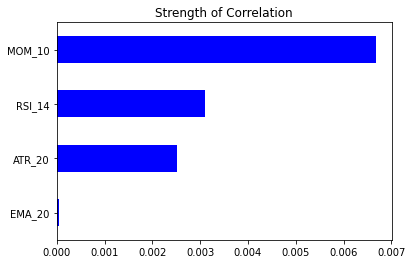

In [22]:
# Strenght of correlation between all features dependent variable (t+1 returns)

corr_t1 = df.corrwith(outcomes['t1_returns'])
corr_t1.sort_values().plot.barh(color = 'blue',title = 'Strength of Correlation')

<AxesSubplot:title={'center':'Strength of Correlation'}>

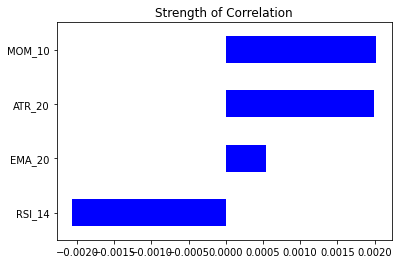

In [23]:
# Strenght of correlation between all features dependent variable (t+5 returns)

corr_t5 = df.corrwith(outcomes['t5_returns'])
corr_t5.sort_values().plot.barh(color = 'blue',title = 'Strength of Correlation')

<AxesSubplot:title={'center':'Strength of Correlation'}>

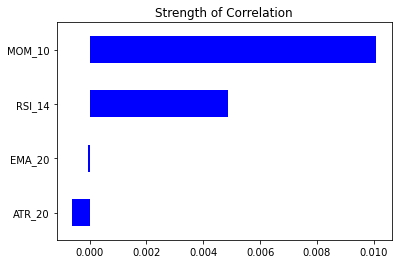

In [24]:
# Strenght of correlation between all features dependent variable (t+10 returns)

corr_t10 = df.corrwith(outcomes['t10_returns'])
corr_t10.sort_values().plot.barh(color = 'blue',title = 'Strength of Correlation')

<AxesSubplot:title={'center':'Strength of Correlation'}>

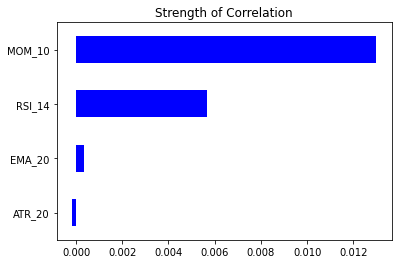

In [25]:
# Strenght of correlation between all features dependent variable (t+20 returns)

corr_t20 = df.corrwith(outcomes['t20_returns'])
corr_t20.sort_values().plot.barh(color = 'blue',title = 'Strength of Correlation')

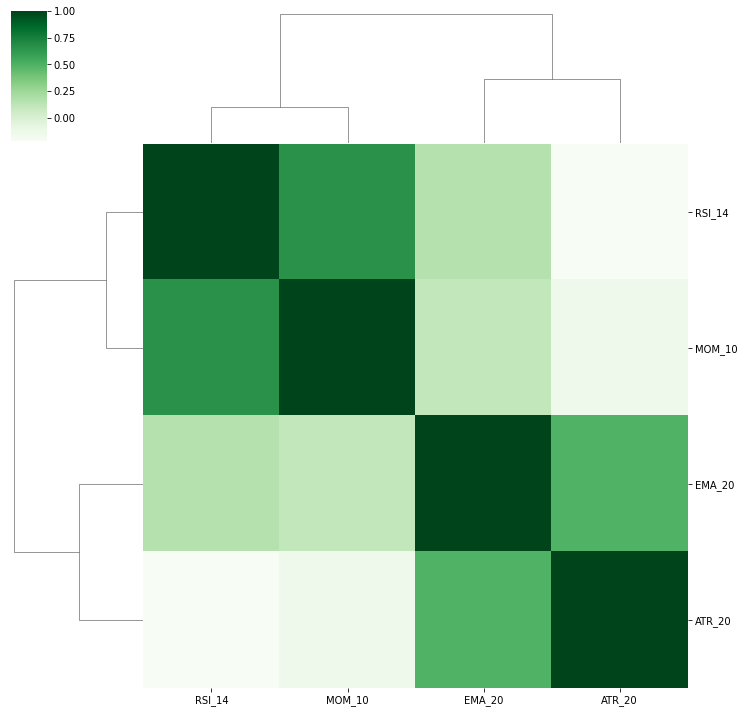

In [26]:
# Plot a heatmap to visualize correlation between features.

corr_matrix = df.corr()
correlations_array = np.asarray(corr_matrix)

linkage = hierarchy.linkage(distance.pdist(correlations_array), \
                            method='average')

g = sns.clustermap(corr_matrix,row_linkage=linkage,col_linkage=linkage,\
                   row_cluster=True,col_cluster=True,figsize=(10,10),cmap='Greens')
plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.show()

label_order = corr_matrix.iloc[:,g.dendrogram_row.reordered_ind].columns

A we can see, there are clusters of features that are similar to each other.

Now, Let's next focus in only on those features with correlation strenghts of greater than 0.0003 to exclude the noise and weak features. (For t+20)

In [27]:
corr_t20

RSI_14    0.005681
EMA_20    0.000341
ATR_20   -0.000172
MOM_10    0.012998
dtype: float64

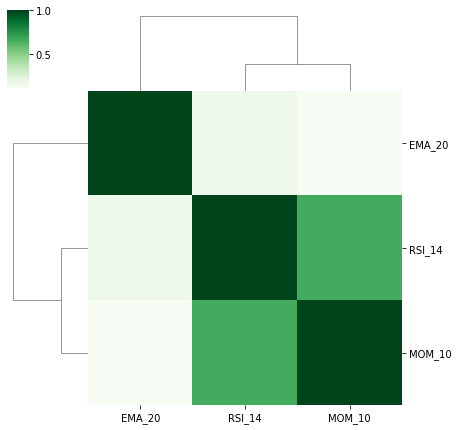

Correlation Strength:
MOM_10    0.012998
RSI_14    0.005681
EMA_20    0.000341
dtype: float64


In [31]:
correlated_features = corr_t20[corr_t20>0.0003].index.tolist()
corr_matrix = df[correlated_features].corr()
correlations_array = np.asarray(corr_matrix)

linkage = hierarchy.linkage(distance.pdist(correlations_array), \
                            method='average')

g = sns.clustermap(corr_matrix,row_linkage=linkage,col_linkage=linkage,\
                   row_cluster=True,col_cluster=True,figsize=(6,6),cmap='Greens')
plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.show()

label_order = corr_matrix.iloc[:,g.dendrogram_row.reordered_ind].columns
print("Correlation Strength:")
print(corr_t20[corr_t20>0.0003].sort_values(ascending=False))

ATR(20) got filtered out.

We'll follow a simple heuristic to manually select the features.

Step 1: Take the most strongly correlated feature (MOM_10) and add it to our list of selected features.

Step 2: Take the second correlated feature (RSI_14) and check to see if it's closely correlated (neighboring in the clustermap) to any features already chosen. If no, add to the list. If yes, discard.

Step 3: Repeat this process until either (1) we've reached the target feature count, or (2) we've run out strongly correlated features.

We should encode this heuristic into an algorithm to do the selections.

Following this heuristic, I get the below features:

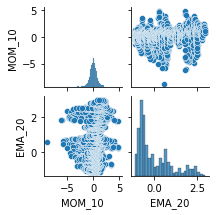

In [32]:
# RSI got filtered out because it's very correlated with MOM. Both are momentum indicators, so that makes sense.

selected_features = ['MOM_10','EMA_20']

import seaborn as sns

sns.pairplot(df[selected_features],size=1.5)

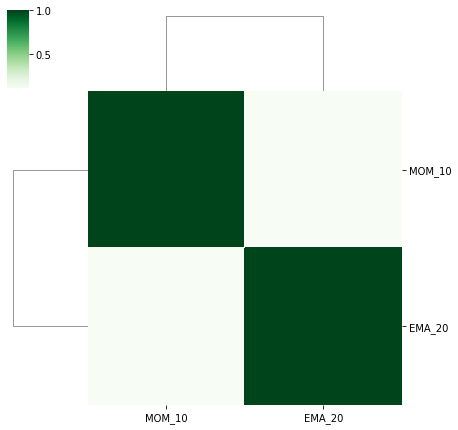

In [33]:
corr_matrix = df[selected_features].corr()
correlations_array = np.asarray(corr_matrix)

linkage = hierarchy.linkage(distance.pdist(correlations_array), method='average')

g = sns.clustermap(corr_matrix,row_linkage=linkage,col_linkage=linkage,\
                   row_cluster=True,col_cluster=True,figsize=(6,6),cmap='Greens')
plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.show()

label_order = corr_matrix.iloc[:,g.dendrogram_row.reordered_ind].columns

As we can see correlations between MOM_10 and EMA_20 is low.

In [ ]:
# Plot the rolling correlation between the selected features.
# Correlations aren't forever in time-series data

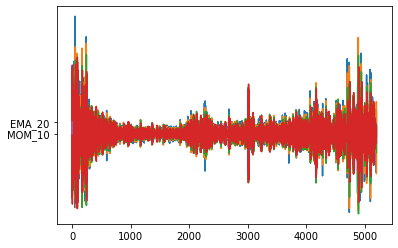

In [47]:
plt.plot(outcomes_scaled[-100:])
plt.plot(selected_features[-100:])